In [1]:
# For Google Colab
# !pip install roboflow
# !pip install -U transformers
# !pip install datasets
# !pip install wandb
# !pip install accelerate -U

In [2]:
import yaml

import wandb
import torch
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms

from datasets import load_dataset, DatasetDict, load_metric
from transformers import ViTForImageClassification, TrainingArguments, Trainer, AutoImageProcessor, ResNetForImageClassification

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
def load_config(config_path):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

In [4]:
def create_transform(aug_config):
    transform_list = []

    # Add transforms based on configuration
    if 'random_resize_crop' in aug_config:
        transform_list.append(transforms.RandomResizedCrop(**aug_config['random_resize_crop']))
    if 'random_horizontal_flip' in aug_config:
        transform_list.append(transforms.RandomHorizontalFlip(aug_config['random_horizontal_flip']))
    if 'color_jitter' in aug_config:
        transform_list.append(transforms.ColorJitter(**aug_config['color_jitter']))
    if 'random_rotation' in aug_config:
        transform_list.append(transforms.RandomRotation(aug_config['random_rotation']))

    # Always include resizing
    transform_list.extend([
        transforms.Resize((224, 224)),
    ])

    return transforms.Compose(transform_list)

In [5]:
def get_transforms(config):
    return create_transform(config['data']['train_augmentation']), create_transform(config['data'].get('val_augmentation', {}))

In [6]:
f_run_config = "config-vit.yml"
f_wandb_config = "wandb.yml"

In [7]:
# Load configuration
config = load_config(f_run_config)
wandb_config = load_config(f_wandb_config)

In [8]:
# Get transforms
train_transform, base_transform = get_transforms(config)

In [9]:
# Load the ds
ds = load_dataset("dduka/guitar-chords")

Repo card metadata block was not found. Setting CardData to empty.


In [10]:
labels = ds['train'].features['label']

In [12]:
model_name = config['model']['name']

if model_name == 'vit':
    model = ViTForImageClassification.from_pretrained(
        config['model']['pretrained_weights'],
        num_labels=len(labels.names),
        id2label={str(i): c for i, c in enumerate(labels.names)},
        label2id={c: str(i) for i, c in enumerate(labels.names)},
        ignore_mismatched_sizes=True
    )
elif model_name == 'resnet152':
    model = ResNetForImageClassification.from_pretrained(
        config['model']['pretrained_weights'],
        num_labels=len(labels.names)
    )
else:
    raise ValueError(f"Model {model_name} not supported")

processor = AutoImageProcessor.from_pretrained(config['model']['pretrained_weights'])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [13]:
def transform(batch, is_train=True):
    # Resize the images to the desired size
    train_transforms, base_transforms = get_transforms(config)
    if is_train:
        processed_images = [train_transforms(x.convert("RGB")) for x in batch['image']]
    else:
        processed_images = [base_transforms(x.convert("RGB")) for x in batch['image']]

    inputs = processor(processed_images, return_tensors='pt')
    inputs['label'] = batch['label']

    return inputs

In [14]:
# Split the data
ds = DatasetDict({
    'train': ds['train'].with_transform(lambda batch: transform(batch, True)),
    'test': ds['test'].with_transform(lambda batch: transform(batch, False)),
    'valid': ds['validation'].with_transform(lambda batch: transform(batch, False))
})

In [15]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load_metric("accuracy")

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


In [16]:
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [17]:
# Initialize wandb
wandb.require("core")
wandb.init(
    project=wandb_config["project"],
    name=wandb_config['name'] + "-" + wandb.util.generate_id(),
    config=wandb_config,
    entity=wandb_config["entity"]
)

# Define training arguments
training_args = TrainingArguments(
    output_dir=config['training']['output_dir'],
    num_train_epochs=config['training']['num_epochs'],
    per_device_train_batch_size=config['training']['batch_size'],
    per_device_eval_batch_size=config['training']['batch_size'],
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=float(config['training']['learning_rate']),
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="wandb",
    remove_unused_columns=False,
    logging_steps=500,
    save_total_limit=1,
    # fp16=True
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ds["train"],
    eval_dataset=ds["valid"],
    compute_metrics=compute_metrics,
    tokenizer=processor
)

# Train the model
trainer.train()

# # Save the fine-tuned model
trainer.save_model(config['training']['final_model_path'])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dhimitrios-duka1 (hwga-cj). Use `wandb login --relogin` to force relogin


In [18]:
metrics = trainer.evaluate(ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

100%|██████████| 9/9 [00:21<00:00,  2.33s/it]

***** test metrics *****
  eval_accuracy           =     0.0845
  eval_loss               =     2.4053
  eval_runtime            = 0:00:24.14
  eval_samples_per_second =      5.881
  eval_steps_per_second   =      0.373


100%|██████████| 9/9 [00:18<00:00,  2.03s/it]


Recall for A: 0.13
Recall for Am: 0.00
Recall for B: 0.00
Recall for Bm: 0.00
Recall for C: 0.14
Recall for D: 0.07
Recall for Dm: 0.00
Recall for E: 0.00
Recall for Em: 0.10
Recall for F: 0.00
Recall for G: 0.43


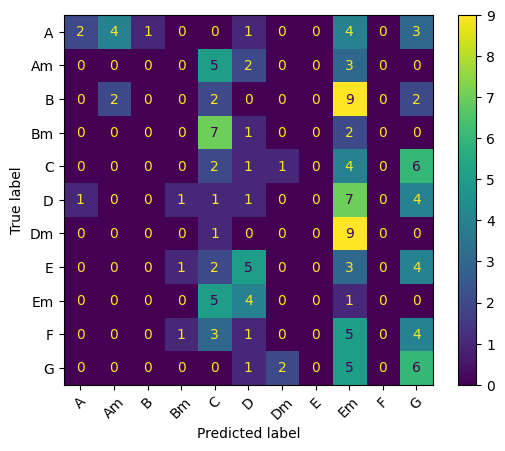

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

test_ds = ds['test']
test_outputs = trainer.predict(test_ds)

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
  print(f"Recall for {label}: {score:.2f}")

In [20]:
# Close wandb run
wandb.finish()

eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
test/accuracy,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
train/global_step,▁
